コラボへのリンク

https://colab.research.google.com/drive/1wyZ_8mxRvrkftzwg2_bep8urj1TdI8A-?usp=sharing

# はじめに

GAN(DCGAN)を用いてアニメキャラクターの顔生成を行う。14397枚のアニメキャラクターの顔画像を使用してGANの訓練を行う。

モデルはDCGANを使用する。


1. TPU+TFRecordを使用して画像を高速に学習させる.


### 前準備

GCSのアクセスキーなどのパラメータを受け取るためHydraを使用.

In [ ]:
!pip install hydra-core --upgrade #hydraをインストール

### import

In [2]:
import gdown #google driveダウンロード用
from glob import glob #ファイル名取得

#その他汎用ライブラリ
import math 
import matplotlib.pyplot as plt
from hydra import initialize, compose
import os
import time 
import seaborn as sns


#機械学習用ライブラリ
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import History #Historyコールバック用

AUTOTUNE = tf.data.AUTOTUNE #並列化用

### TPU

高速化のためにTPUを使用する。

In [3]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.69.216.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.216.34:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [4]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


### 変数宣言

事前に変数を宣言しておいての一つのコラムで実行できるようにする。

In [5]:
#Hydraファイル読み込み
config_path = "./drive/MyDrive/data/imouto_face/config"
with initialize(version_base=None, config_path= config_path):
    cfg = compose(config_name="variable.yaml")

In [6]:
SHARDS = 16 #分割数
TARGET_SIZE = (64,64) #サイズ
file_paths = [] #画像パス
nb_images = 14397 #画像数
shard_size = 900 #分割画像数
GCS_OUTPUT = cfg.gcs.gcs_output #GCSのOUTPUTPATH
BATCH_SIZE = 128 #バッチサイズ
latent_dim = 100 #潜在空間

In [7]:
#GCSへアクセスするためのパスを通す
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=cfg.gcs.token_path

In [8]:
#画像表示関数
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, image  in enumerate(dataset):
    image /= 255
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy())
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

## 前処理

データセットを前処理し訓練を行いやすくする

1. データセットをダウンロード
2. TPUから使えるようにTFrecordへ変換
3. GoogleCloudStorageへと転送

### データ準備

データセットは下記のURLからダウンロード GoogleDriveに転送する

https://www.kaggle.com/reitanaka/alignedanimefaces

GANを行うということで、簡単なタスクである顔の生成を選んだ。実写顔の生成は以前行ったので、アニメ顔の生成を行うべくこのデータセットを選択。

In [ ]:
#データをgoogleDriveからコピー
!cp /content/drive/MyDrive/data/imouto_face/moeimouto-faces.zip ./

In [ ]:
#unzip
!unzip /content/moeimouto-faces.zip

Archive:  /content/moeimouto-faces.zip
replace moeimouto-faces/080_koizumi_itsuki/face_313_336_66.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#ファイルパスを取得する
files = glob("/content/moeimouto-faces/*")
for file in files: 
  file_paths += (glob(file + "/*.png"))

In [ ]:
#ファイル数を確認 (変数へ転記)
nb_images = len(file_paths)
print(f"num of files : {nb_images}")

num of files : 14397


In [ ]:
#分割数を求める
shard_size = math.ceil(1.0 * nb_images / SHARDS) #小数点切り捨て
print(f"分割画像数 : {shard_size}")

分割画像数 : 900


In [ ]:
#pngをデコードする関数
def decode_png(filename):
  bits =  tf.io.read_file(filename)
  image = tf.io.decode_png(bits, channels = 3) #強制3チャンネルに(アルファをカット)
  return image

In [ ]:
#jpegをデコードする関数
def decode_jpeg(filename):
  bits =  tf.io.read_file(filename)
  image = tf.io.decode_jpeg(bits)
  return image

In [ ]:
#画像をいい感じにトリミングしてくれる
def resize_and_crop_image(image):
  w = tf.shape(image)[0] #現在の画像サイズ
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[0] #目標画像サイズ
  th = TARGET_SIZE[1]
  resize_crit = (w * th) / (h * tw) #アスペクト比
  #tf.confは条件付関数割り当て
  #横のほうが長い場合 : True
  #縦のほうが長い場合 : False
  #アスペクト比を維持したままTargetSizeに合わせる
  image = tf.cond(resize_crit < 1, 
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  #真ん中でクロップして終わり
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image

In [ ]:
#ディレクトリからデータセット作成
def preprocessing_data(file_paths):
  #ファイル読み込み
  filenames = tf.data.Dataset.from_tensor_slices(file_paths) #ファイルパスデータセット作成
  dataset = filenames.map(decode_png, num_parallel_calls=AUTOTUNE) #ファイル読み込み
  dataset = dataset.map(resize_and_crop_image, num_parallel_calls=AUTOTUNE) #画像変換
  return dataset

In [ ]:
#データセット作成
datasets = preprocessing_data(file_paths)
print(datasets)

<ParallelMapDataset element_spec=TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None)>


### EDA ? 

顔が入るようトリミングされているが顔の位置がバラバラ

背景が複雑な画像が多い

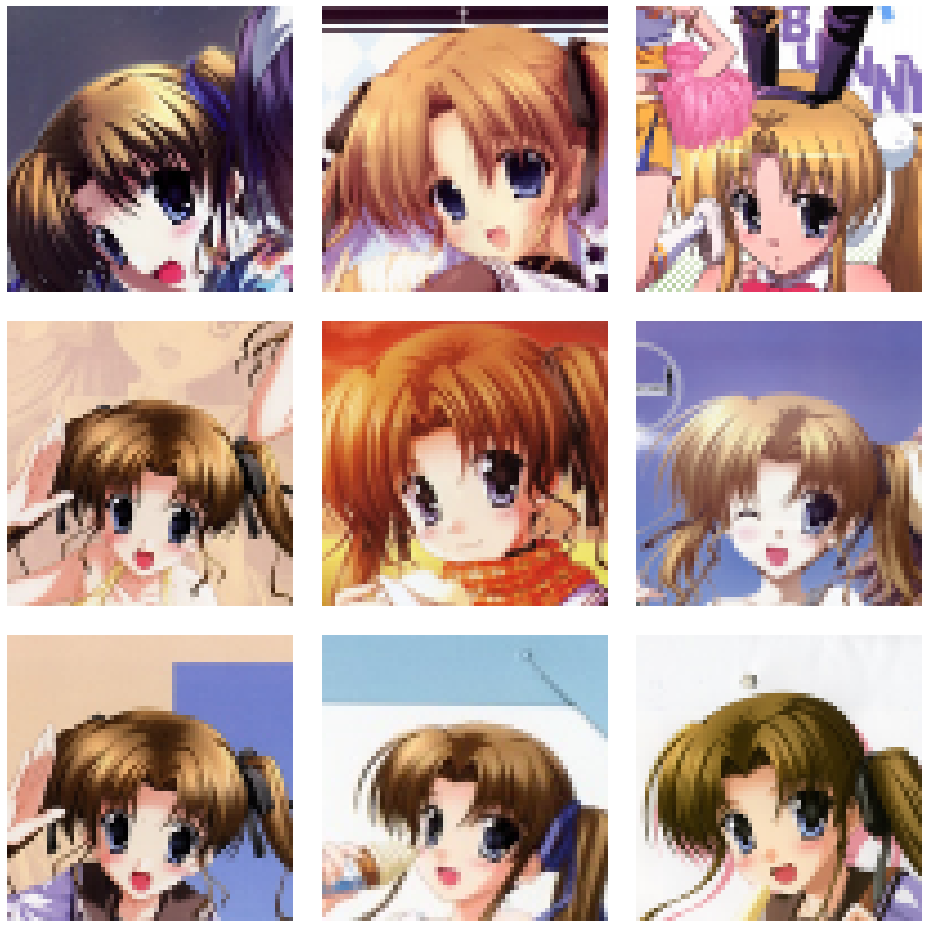

In [ ]:
#画像を確認
display_9_images_from_dataset(datasets)

### TFRecordに変換しGCSへアップロード

In [ ]:
#再エンコード
def recompress_image(image):
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image

datasets_comp = datasets.map(recompress_image, num_parallel_calls=AUTOTUNE)
datasets_comp = datasets_comp.batch(shard_size) # 分割数ごとにバッチ化

In [ ]:
#TFRecord変換コード
def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def to_tfrecord(img_bytes):  

  feature = {
      "image": _bytestring_feature([img_bytes]) #1画像をリストに入れる
  }

  return tf.train.Example(features=tf.train.Features(feature=feature)) #tf.train.Exampleメッセージにする必要あり, feature=tf.train.Features(シリアライズされたfeatureインスタンス)


In [ ]:
#TFRecordへ変換し、転送する

print("Writing TFRecords")

for shard, image in enumerate(datasets_comp):
  #バッチサイズを取得
  shard_size = image.numpy().shape[0]
  #ファイル名をつける (BP)
  filename = GCS_OUTPUT + "/{:02d}-{}.tfrec".format(shard, shard_size)

  #TFRecordに書き出し
  with tf.io.TFRecordWriter(filename) as out_file:
    #一枚ずつシリアライズ
    for i in range(shard_size):
      example = to_tfrecord(
                            image.numpy()[i]
                            )
      #シリアライズ化
      out_file.write(example.SerializeToString()) #転送
    print("Wrote file {} containing {} records".format(filename, shard_size)) #転送結果を表示

Writing TFRecords
Wrote file gs://my-kaglle-getting-started/imoto-face/00-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/01-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/02-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/03-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/04-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/05-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/06-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/07-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/08-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/09-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/10-900.tfrec containing 900 records
Wro

## 前処理が終わった場合ここから実行する

### データセットをCGSからダウンロード

In [9]:
def read_tfrecord(example):
    #戻すfeature要素を定義
    features = {
        "image": tf.io.FixedLenFeature([], tf.string)
    }
    #TFRecordをデコード
    example = tf.io.parse_single_example(example, features)
      
    #imageをデコード(3channel)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    #形を整える
    image = tf.reshape(image, [*TARGET_SIZE, 3])

    return image

In [10]:
#順番を不問にして高速化
option_no_order = tf.data.Options()
option_no_order.deterministic  = False

#ダウンロード
filenames = tf.io.gfile.glob(GCS_OUTPUT + "/*.tfrec")
datasets = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) #デコード用構造体定義
datasets = datasets.with_options(option_no_order) #オプション設定
datasets = datasets.map(read_tfrecord, num_parallel_calls=AUTOTUNE) #TFをデコード
datasets = datasets.shuffle(300) #シャッフル

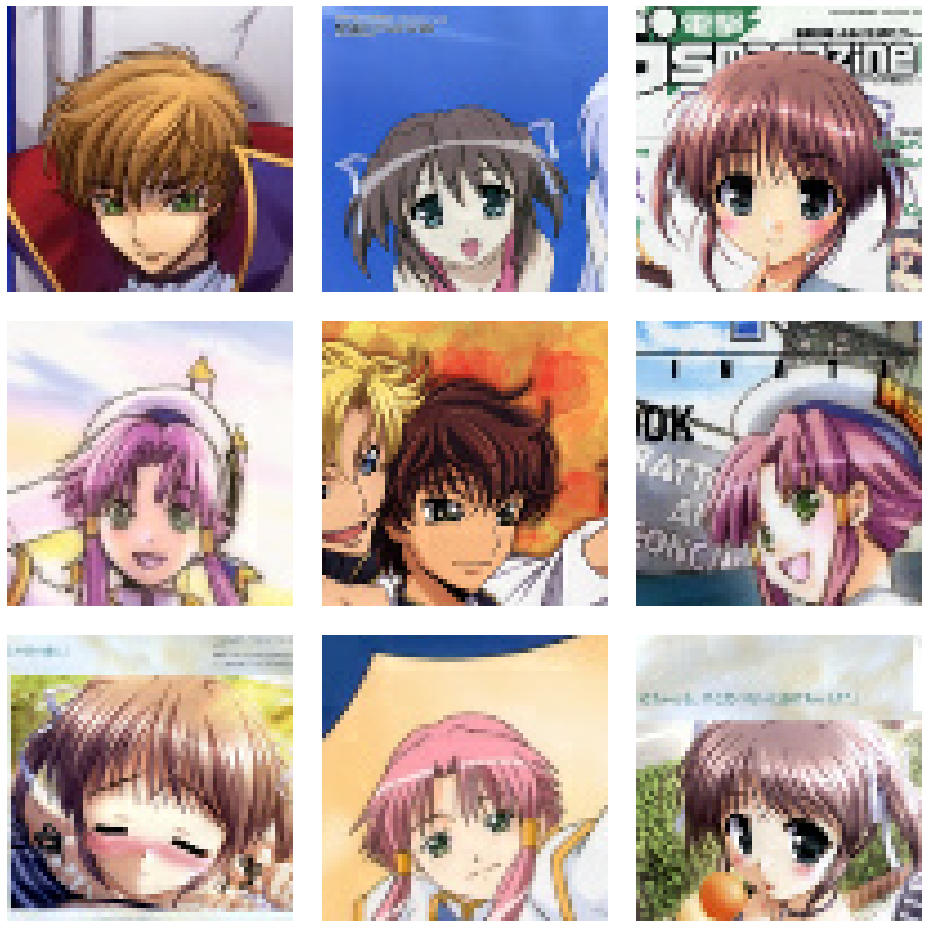

In [11]:
display_9_images_from_dataset(datasets) #確認

In [12]:
### 再度JPEGから変換する

def preprocess(image):
  image = tf.cast(image, tf.float32)

  # 0 1 の範囲で正規化する
  #image /= 255.0

  # -1 1 の範囲で正規化する

  # PART6
  # 学習がうまくいかなかったので -1, 1の範囲で画像を正規化する

  image =  2 * image / 255 - 1

  return image

In [41]:
#dsを変換
ds = datasets.map(preprocess)

In [42]:
ds = ds.shuffle(buffer_size=nb_images) #シャッフル
ds = ds.repeat() #無限化
ds = ds.batch(BATCH_SIZE) #バッチで区切る
ds = ds.prefetch(buffer_size=AUTOTUNE) #事前取得で高速化
ds #一応確認

<PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

### ベースライン作成

In [83]:
#discriminator

def build_discriminator():
  input = layers.Input(shape=(64,64,3)) #64,64,3カラー
  feature = layers.Conv2D(64, (5,5), strides=(2,2), padding="same")(input)
  feature = layers.LeakyReLU()(feature) 
  feature = layers.BatchNormalization()(feature)
  feature = layers.Conv2D(64 * 2, (5,5), strides=(2,2), padding="same")(feature)
  feature = layers.LeakyReLU()(feature)
  feature = layers.BatchNormalization()(feature)
  feature = layers.Conv2D(64 * 2 * 2, (5,5), strides=(2,2), padding="same")(feature)
  feature = layers.LeakyReLU()(feature)
  feature = layers.BatchNormalization()(feature)
  feature = layers.Flatten()(feature)
  output = layers.Dense(1, activation="sigmoid")(feature) #2値なので

  discriminator = tf.keras.Model(inputs = input , outputs = output)

  return discriminator

discriminator = build_discriminator()
discriminator.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_90 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_90 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_36 (Conv2D)          (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_91 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                          

In [87]:
#Generator
def build_generator():
  latent_dim = 100 #潜在次元が100
  input = layers.Input(shape = (100,))
  feature = layers.Dense(8*8*256, use_bias=False)(input) #バイアスなし 画像を膨らます
  feature = layers.BatchNormalization()(feature)
  feature = layers.LeakyReLU()(feature)
  feature = layers.Reshape((8,8,256))(feature)

  # PART11
  #Layerを圧縮 
  '''
  feature = layers.Conv2DTranspose(64 * 2 * 2 , (5,5) ,strides=(1,1), padding="same", use_bias=False)(feature) #第一層はStridesが(1,1)がBP？
  feature = layers.BatchNormalization()(feature)
  feature = layers.LeakyReLU()(feature)
  '''
  feature = layers.Conv2DTranspose(64 * 2 , (5,5) ,strides=(2,2), padding="same", use_bias=False)(feature)
  feature = layers.BatchNormalization()(feature)
  feature = layers.LeakyReLU()(feature)
  feature = layers.Conv2DTranspose(64 , (5,5) ,strides=(2,2), padding="same", use_bias=False)(feature)
  feature = layers.BatchNormalization()(feature)
  feature = layers.LeakyReLU()(feature)
  #PART9
  #activationをtanhに
  feature = layers.Conv2DTranspose(3 , (5,5) ,strides=(2,2), padding="same", use_bias=False, activation="tanh")(feature)

  generator = tf.keras.Model(inputs=input, outputs=feature)

  return generator

generator = build_generator()
generator.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_32 (Dense)            (None, 16384)             1638400   
                                                                 
 batch_normalization_104 (Ba  (None, 16384)            65536     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_104 (LeakyReLU)  (None, 16384)            0         
                                                                 
 reshape_19 (Reshape)        (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_68 (Conv2D  (None, 16, 16, 128)      819200    
 Transpose)                                               

In [88]:
class GAN(tf.keras.Model): #クラス作成
  def __init__(self, discriminator, generator, latent_dim):  #コンストラクタ
    super().__init__() #継承
    self.discriminator = discriminator #識別機 
    self.generator = generator #生成器
    self.latent_dim = latent_dim # 潜在次元
    #評価関数を定義
    self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss") #Batchすべての評価をとる.結果の平均をとる
    self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss") 

  def compile(self, d_optimizer, g_optimizer, loss_fn): #最適化を2つ作成
    super(GAN,self).compile() #継承
    self.d_optimizer = d_optimizer #discriminator用のOptimizer
    self.g_optimizer = g_optimizer #Generator用のOptimizer
    self.loss_fn = loss_fn

  @property
  def matrics(self):
    return [self.d_loss_metric, self.g_loss_metric] #評価関数を設定

  def train_step(self, real_images): #trainのoverride
    batch_size = tf.shape(real_images)[0]  # (batch, height, width, channel) バッチ数を半分確保
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim)) #バッチ数分潜在空間から画像の種を作成
    genereated_image = self.generator(random_latent_vectors) #画像を生成
    combined_image = tf.concat([real_images, genereated_image], axis=0) #縦に結合
    #真画像 : 1,  偽画像 : 0
    combined_label = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0) #ラベルを作成
    
    combined_label += 0.1 *tf.random.uniform(tf.shape(combined_label)) #ラベルにノイズを入れる
    
    #学習を行う
    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_image) #予測
      #d_loss = self.loss_fn(combined_label, predictions) #損失を取得

      #PART3
      #TPUのために損失をバッチサイズ分割る
      d_loss = tf.reduce_sum(self.loss_fn(combined_label, predictions)) * (1. / 128) 


    grads = tape.gradient(d_loss, self.discriminator.trainable_weights) #損失からウェイトを取得
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights)) #ウェイト調整

    #generator
    random_latent_vector = tf.random.normal(shape=(batch_size, self.latent_dim))
    misleading_label = tf.ones((batch_size, 1)) #真の値でラベルを付ける
    with tf.GradientTape() as tape:
      predictions = self.discriminator(self.generator(random_latent_vector)) #偽画像を予測
      #g_loss = self.loss_fn(misleading_label, predictions) #損失に入れる
      g_loss = tf.reduce_sum(self.loss_fn(misleading_label, predictions)) * (1. / 128)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss) #損失から評価する
    self.g_loss_metric.update_state(g_loss) #損失から評価する
    return {"d_loss" : self.d_loss_metric.result(), "g_loss" : self.g_loss_metric.result()}


### Google Colab のリージョン確認

GCSの無料枠のために確認

In [17]:
#gpingインストール
! curl https://storage.googleapis.com/gcping-release/gcping_linux_amd64_latest > gcping && chmod +x gcping

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6375k  100 6375k    0     0  30.3M      0 --:--:-- --:--:-- --:--:-- 30.3M


In [18]:
#低ping値の場所がTPUサーバーぽい
! /content/gcping

 1.  [us-central1]              7.094542ms
 2.  [global]                   11.092202ms
 3.  [us-south1]                22.153587ms
 4.  [us-east5]                 25.351259ms
 5.  [northamerica-northeast2]  27.747973ms
 6.  [us-west3]                 28.817933ms
 7.  [us-east4]                 31.238873ms
 8.  [northamerica-northeast1]  34.368975ms
 9.  [us-east1]                 38.819399ms
10.  [us-west1]                 45.34193ms
11.  [us-west4]                 49.476095ms
12.  [us-west2]                 53.414206ms
13.  [europe-west2]             100.313565ms
14.  [europe-west9]             107.985023ms
15.  [europe-west4]             108.62079ms
16.  [europe-west1]             111.177332ms
17.  [europe-west3]             116.348286ms
18.  [europe-west6]             122.72924ms
19.  [europe-west8]             124.946289ms
20.  [europe-southwest1]        125.499616ms
21.  [europe-central2]          131.156965ms
22.  [europe-north1]            133.834618ms
23.  [southamerica-east1] 

### テスト用コード

In [56]:
#画像保存テスト
random_latent_vector = tf.random.normal(shape=(3, 100)) #画像シード作成
generated_imgs = generator(random_latent_vector)
#generated_imgs *= 255 #画像を復元
generated_imgs = (generated_imgs + 1) * 255 / 2
generated_imgs = generated_imgs.numpy() #npに変換
generated_img = generated_imgs[0]
pil_img = tf.keras.utils.array_to_img(generated_img)
hoge = "/content/drive/MyDrive/data/imouto_face/GAN_result" + f"/{time.time()}.jpeg"
pil_img.save(hoge)

### コールバック

In [89]:
class GanMonitor(tf.keras.callbacks.Callback): #コールバック作成
  def __init__(self, log_dir, num_img = 1, latent_dim = 100):
    self.num_img = num_img #画像の生成数
    self.latent_dim = latent_dim #潜在次元
    self.log_dir = log_dir
  def on_epoch_end(self, epoch, logs=None): #エポックの後に動く画像
    random_latent_vector = tf.random.normal(shape=(self.num_img, self.latent_dim )) #画像シード作成
    generated_imgs = self.model.generator(random_latent_vector)
    generated_imgs = (generated_imgs + 1) * 255 / 2
    generated_imgs = generated_imgs.numpy() #npに変換
    for idx, generated_img in enumerate(generated_imgs):
      pil_img = tf.keras.utils.array_to_img(generated_img)
      output_path = self.log_dir + f"/{time.time()}_{idx+1}.jpeg" 
      pil_img.save(output_path)

In [98]:
#TPUではtensorboardをうまく使えないのでhistory型で履歴を残す

#履歴用のhistory
history = History() 

In [99]:
callbacks = [GanMonitor("/content/drive/MyDrive/data/imouto_face/GAN_result/PART11"), history] #コールバックを宣言

In [91]:
#TPUのスコープでモデルを作成
with strategy.scope():
  
  generator = build_generator() #ジェネレータ
  discriminator = build_discriminator() #ディスクリミネータ
  model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim) #モデル作成 

  #PART2
  #ReductionをNoneに

  #PART9
  #Adamのレートを0.5に
  
  model.compile(loss_fn=tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE), 
              d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5), 
              g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5))  

TPUでは画像をWorkerで分割しその結果を合計することでlossを算出する.

TPUの場合はReductionをNONE or SUMを選べる。 正しく計算するためには何も行わないNONEを選択しモデル関数内でlossをBATCH_SIZEで割る

https://www.tensorflow.org/tutorials/distribute/custom_training

In [103]:
#学習

#PART11
#EPCOHを増やす

epochs = 800
steps_per_epoch = nb_images // BATCH_SIZE #画像一周分
model.fit(ds, epochs=epochs,  steps_per_epoch=steps_per_epoch, callbacks=callbacks)

Epoch 1/800
  5/112 [>.............................] - ETA: 3s - d_loss: -2.1581 - g_loss: 0.0052WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0056s vs `on_train_batch_end` time: 0.2461s). Check your callbacks.


112/112 [==============================] - 6s 37ms/step - d_loss: -1.9908 - g_loss: 0.1177
Epoch 2/800
112/112 [==============================] - 4s 36ms/step - d_loss: -2.1584 - g_loss: 0.0617
Epoch 3/800
112/112 [==============================] - 4s 32ms/step - d_loss: -2.0394 - g_loss: 0.2060
Epoch 4/800
112/112 [==============================] - 4s 32ms/step - d_loss: -2.0630 - g_loss: 0.0951
Epoch 5/800
112/112 [==============================] - 4s 32ms/step - d_loss: -0.8709 - g_loss: 0.9034
Epoch 6/800
112/112 [==============================] - 3s 31ms/step - d_loss: 3.5446 - g_loss: 2.2764
Epoch 7/800
112/112 [==============================] - 4s 32ms/step - d_loss: -2.0577 - g_loss: 0.0612
Epoch 8/800
112/112 [==============================] - 4s 32ms/step - d_loss: -2.1222 - g_loss: 0.0381
Epoch 9/800
112/112 [==============================] - 4s 33ms/step - d_loss: -2.4617 - g_loss: 0.0340
Epoch 10/800
112/112 [==============================] - 4s 32ms/step - d_loss: -2.4992

EPOCHを800にした結果d_lossの値がとんでもない数値になった。コードをみてもマイナスになる要因がわからない。

### PART11

層を変項 中間層のtransposeを一つ消す 

EPOCHの数を増やす

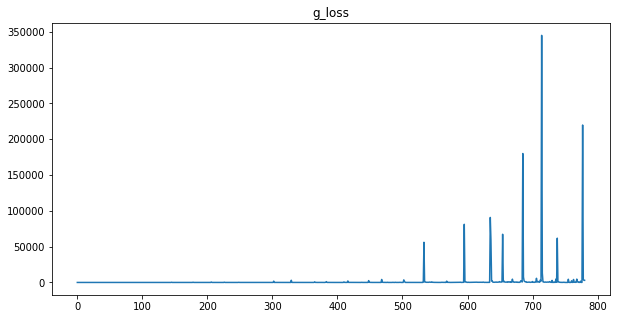

In [104]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["g_loss"][20:])), y = history.history["g_loss"][20:], ax=ax)
plt.title("g_loss")
plt.show()

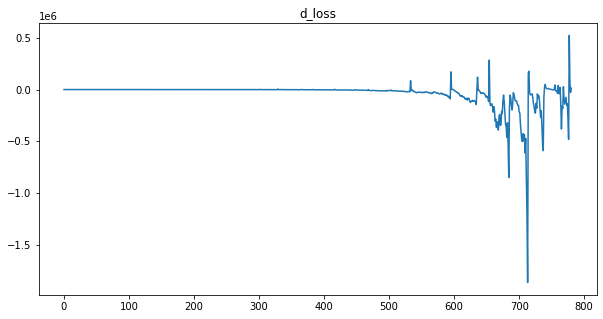

In [105]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["d_loss"][20:])), y = history.history["d_loss"][20:], ax=ax)
plt.title("d_loss")
plt.show()

d_lossがマイナスに落ちていく？？？
g_lossが跳ね上がる

損失関数 or 評価関数が何かがおかしい

生成画像

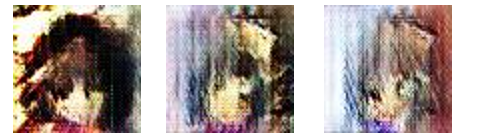

### PART10

Adamのbetaを0.5に変更
discriminatorのlr = 0.002に戻す


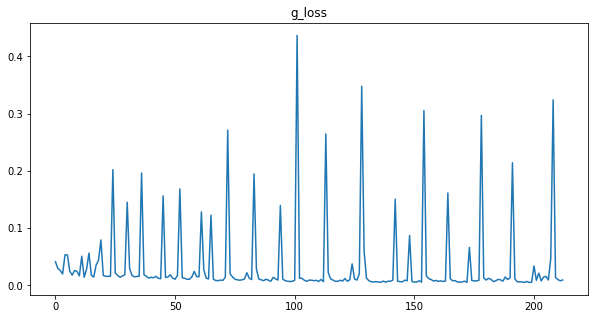

In [70]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["g_loss"][20:])), y = history.history["g_loss"][20:], ax=ax)
plt.title("g_loss")
plt.show()

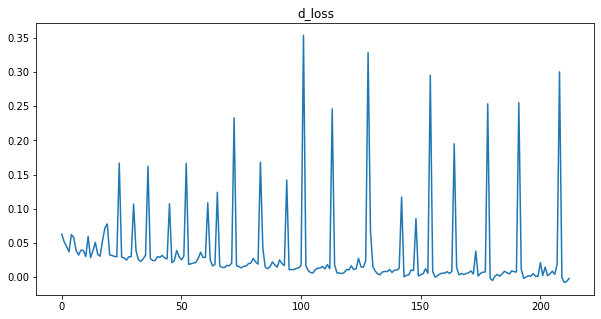

In [71]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["d_loss"][20:])), y = history.history["d_loss"][20:], ax=ax)
plt.title("d_loss")
plt.show()

生成画像

ノイズが減った

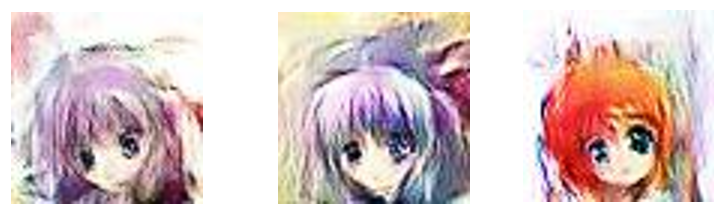

### PART9
Adamのbetaを0.5に変更

discのlr =0.0003

d_lossが上がらない <= disciminatorのActiationをtanhに間違えていた

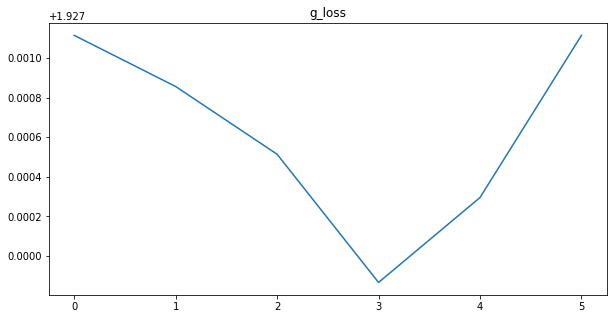

In [48]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["g_loss"][20:])), y = history.history["g_loss"][20:], ax=ax)
plt.title("g_loss")
plt.show()

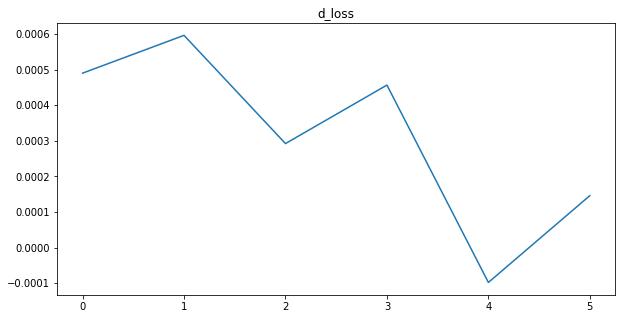

In [49]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["d_loss"][20:])), y = history.history["d_loss"][20:], ax=ax)
plt.title("d_loss")
plt.show()

生成画像

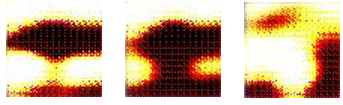

### PART8 

discriminatorのlrを0.0003に変更

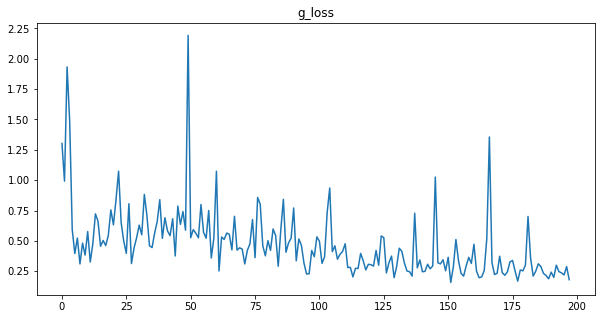

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["g_loss"][20:])), y = history.history["g_loss"][20:], ax=ax)
plt.title("g_loss")
plt.show()

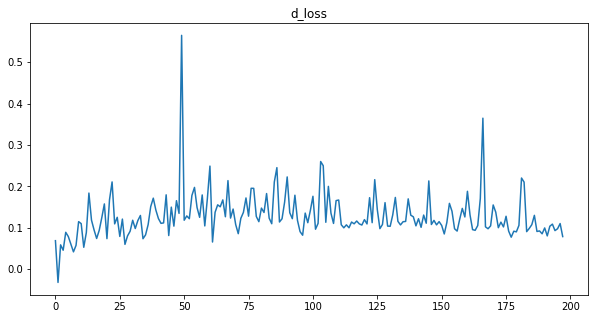

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["d_loss"][20:])), y = history.history["d_loss"][20:], ax=ax)
plt.title("d_loss")
plt.show()

以前の結果と変わらない

生成画像

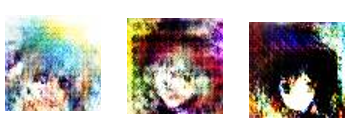

### PART7

generator = 0.0003 に変更

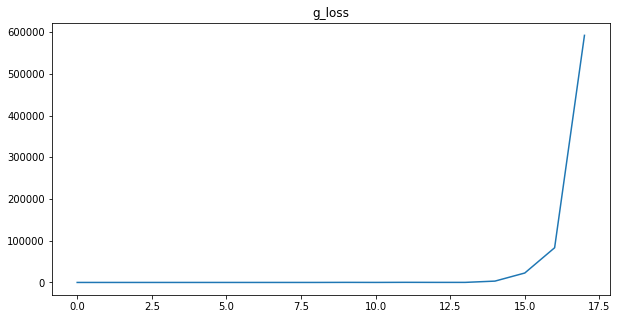

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["g_loss"])), y = history.history["g_loss"], ax=ax)
plt.title("g_loss")
plt.show()

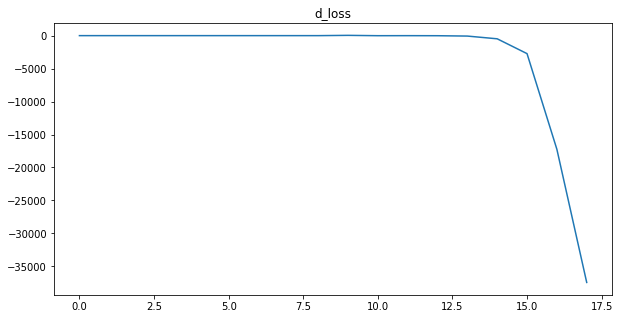

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["d_loss"])), y = history.history["d_loss"], ax=ax)
plt.title("d_loss")
plt.show()

モデルが崩壊したので終了

生成画像

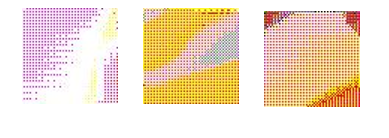

### PART6

画像を (-1, 1) に正規化
tanhに変更

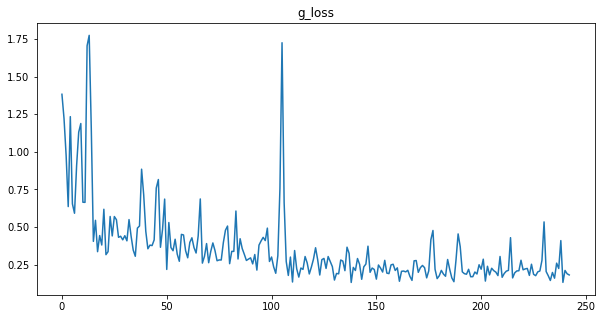

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["g_loss"])), y = history.history["g_loss"], ax=ax)
plt.title("g_loss")
plt.show()

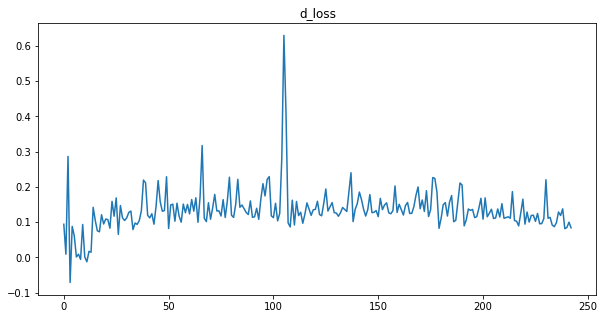

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["d_loss"])), y = history.history["d_loss"], ax=ax)
plt.title("d_loss")
plt.show()

d_lossの均衡が低すぎるので低品質の画像ばかり生成される

生成画像

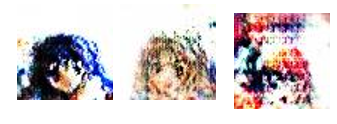

### PART5

ノイズを加えた

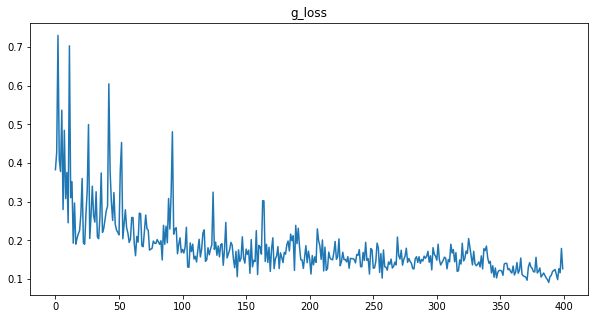

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["g_loss"])), y = history.history["g_loss"], ax=ax)
plt.title("g_loss")
plt.show()

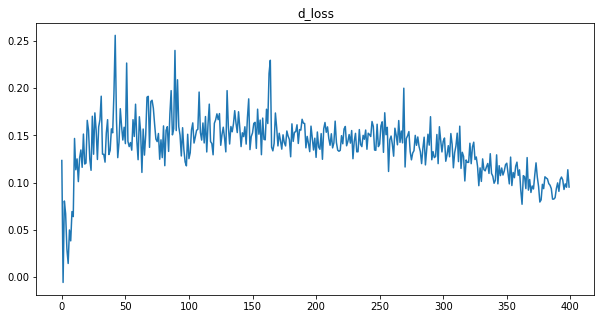

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["d_loss"])), y = history.history["d_loss"], ax=ax)
plt.title("d_loss")
plt.show()

d_lossの均衡が惜しい

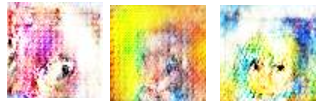

### Part4

ディスクリミネータを2つ付けた

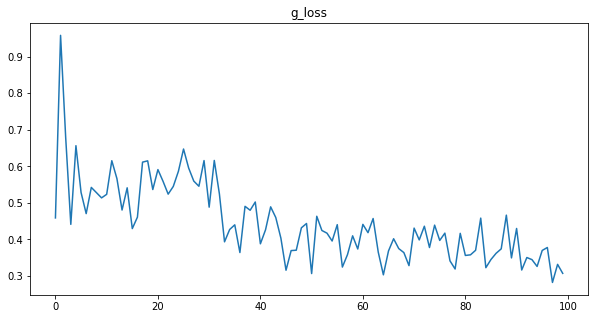

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history["g_loss"][100:])), y = history["g_loss"][100:], ax=ax)
plt.title("g_loss")
plt.show()

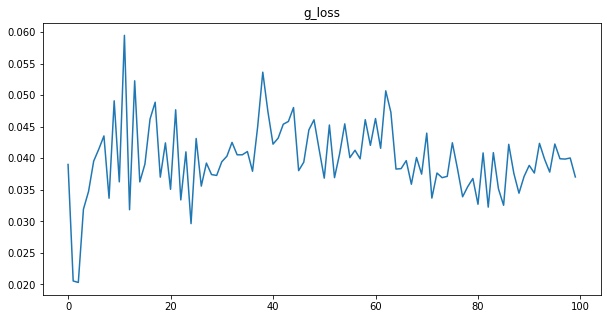

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history["d_loss"][100:])), y = history["d_loss"][100:], ax=ax)
plt.title("g_loss")
plt.show()

discriminatorが強すぎる

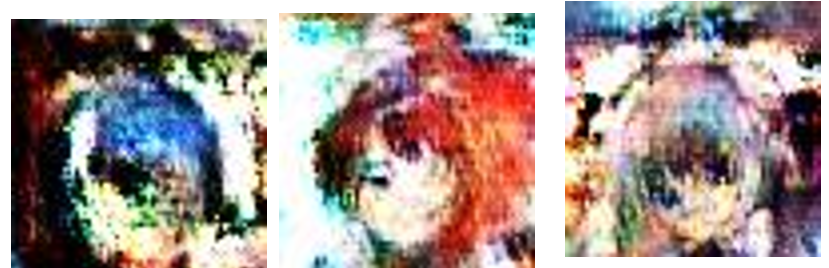

### Part3

ReductionLossを修正

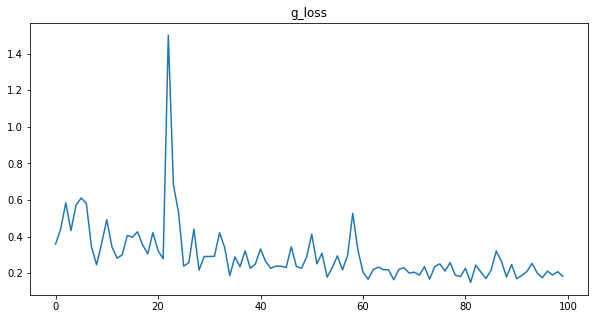

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["g_loss"])), y = history.history["g_loss"], ax=ax)
plt.title("g_loss")
plt.show()

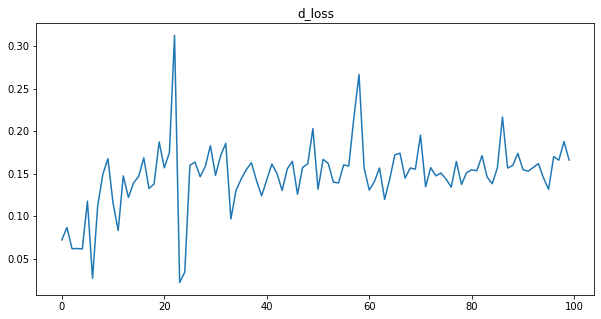

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["d_loss"])), y = history.history["d_loss"], ax=ax)
plt.title("d_loss")
plt.show()

これのd_lossを0.5にすればよい -> d_lossを少し弱くする

出力結果

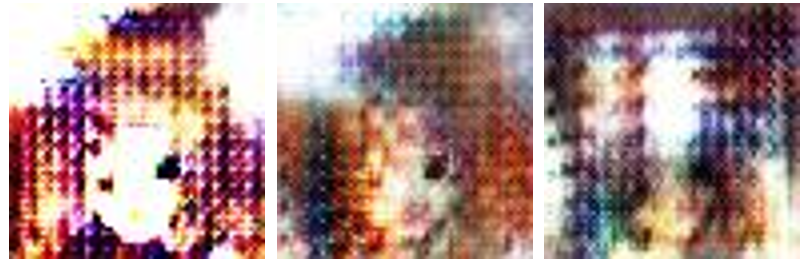

### 考察

d_loss, g_loss曲線がおかしいので何かを修正しないといけない
- d_lossは0.5あたりで均衡がとれると正しく学習できると判定できる
- g_lossが大きくなりすぎるとだませていない

**PART3**

1. Reductionの設定を間違えている (NONEにしてGLOBAL_BATCHSIZEで分割)
-  TPU使用時バッチはワーカごとに分割されて学習される。損失は合計値が返ってくる
- SUM時はワーカで分散されたバッチ数で割られた損失が返ってくるが、NONEにすることによりTPUで分割されたバッチが返ってこなくなる
- 正しいGLOBAL_BATCHSIZE(128)で分割し、ワーカーごとの損失を正しく同期させる

- https://www.tensorflow.org/tutorials/distribute/custom_training


バッチサイズが小さすぎる？
- バッチサイズ分画像を生成しているからバッチサイズを大きくしても意味がない


**PART4**

ディスクリミネータが弱すぎる？
- 考察間違い

ディスクリミネータが少し強い

- g_lossは下がっていってよい(ラベルを付けているので)

**PART5**

ノイズを加える

**PART6**

入力画像を-1, 1 活性化関数をtanhに

単純にEpoch数が少なすぎる？
- 200に変更

**PART7**

generatorのlearning_lateを変更する

崩壊した。

**PART8**

discriminatorのlearning_rateを変更する

品質には影響ない

**PART10**

Adamの第一モーメントを0.5に変更

品質に良い影響あり

**PART11**

1. 層を変更する。
2. Epochの数を増やす

1. 品質には効果なし
2. lossがマイナスを超えて下降していく。 <- モデルがそもそも間違ってる？ 🤮

参考文献

https://qiita.com/underfitting/items/a0cbb035568dea33b2d7

### 結論

試行錯誤を行ったがうまくいかない結果になった。

問題点はgeneratorの性能が低くdiscrimnatorの拮抗ラインが低すぎる点にあると考えられるが、Genratorの性能を上げる手段が不明である。

知見
1. GANはEpoch回数を多く必要とする。200~あたりからまともな生成結果になる